In [1]:
import os
from benchmarkrewriter.benchmark_parser import BenchmarkParser, WorkerBenchmarkParser, WorkerEncoding
import pandas as pd

In [2]:
results_path = r'C:\Users\huda\Downloads\repetitions\repetitions\\'
result_files = os.listdir(results_path)
benchmark_path = r'C:\Users\huda\Documents\GitHub\scheduling_model_jrc\code\upgrades\benchmarks_with_workers'

In [3]:
def worker_flexibility(benchmark : WorkerEncoding):
    n_assignments = 0
    m = benchmark.n_machines()
    o = benchmark.n_operations()
    durations = benchmark.durations()
    w = durations.shape[2]
    for i in range(len(durations)):
        for j in range(len(durations[i])):
            for k in range(len(durations[i][j])):
                if durations[i][j][k] > 0:
                    n_assignments += 1
    average_assignments = n_assignments / o
    return average_assignments / (m*w)

def get_flexibility_and_dv_worker(benchmark):
    all = 0
    unique = []
    machines_available = 0
    durations = benchmark.durations()
    for i in range(len(durations)):
        for j in range(len(durations[i])):
            for k in range(len(durations[i][j])):
                if durations[i][j][k] > 0:
                    if durations[i][j][k] not in unique:
                        unique.append(durations[i][j][k])
                    all += 1
            if any([x > 0 for x in durations[i][j]]):
                machines_available+=1
    #return (machines_available / len(durations)) / benchmark.n_machines(), len(unique) / all
    return worker_flexibility(benchmark), len(unique) / all

In [4]:
def read_single_benchmark(path, benchmark):
    parser = WorkerBenchmarkParser()
    data = parser.parse_benchmark(path + '/' + benchmark)
    f, dv = get_flexibility_and_dv_worker(data)
    return {'n_operations': data.n_operations(), 'n_machines': data.n_machines(), 'n_workers': data.n_workers(), 'flexibility': f, 'duration_variety': dv}
def read_benchmarks_workers(path):
    result = dict()
    benchmarks = os.listdir(path)
    for benchmark in benchmarks:
        #parser = BenchmarkParser()
        parser = WorkerBenchmarkParser()
        data = parser.parse_benchmark(path + '/' + benchmark)
        #f, dv = get_flexibility_and_dv(data)


        result[benchmark] = {'n_operations': data.n_operations(), 'n_machines': data.n_machines()}

    return result

In [5]:
results = dict()
benchmark_data = dict()
for file in result_files:
    file_content = pd.read_csv(results_path + file, names=['name','optimization_status','fitness_value','lower_bound', 'runtime', 'result_vector1', 'result_vector2', 'result_vector3', 'peak_cpu', 'peak_ram', 'resource_history', 'best_result_history'], sep=';')
    df = pd.DataFrame(file_content)
    name = file.split('\\')[-1][8:-4]
    results[name] = dict()
    for index, row in df.iterrows():
        if row['name'].startswith('Error'):
            continue
        if row['name'] not in results[name]:
            results[name][row['name']] = []
        results[name][row['name']].append({
            'fitness': row['fitness_value'],
            'lower_bound': row['lower_bound'],
            'runtime': row['runtime']
        })
        benchmark_data[row['name']] = read_single_benchmark(benchmark_path, row['name'])


In [6]:
import statistics
average_results = dict()
best_results = dict()
max_change = dict()
for solver in results:
    average_results[solver] = dict()
    best_results[solver] = dict()
    max_change[solver] = dict()
    for instance in results[solver]:
        average_results[solver][instance] = dict()
        fitness = [results[solver][instance][i]['fitness'] for i in range(len(results[solver][instance]))]
        lower_bound = [results[solver][instance][i]['lower_bound'] for i in range(len(results[solver][instance]))]
        runtime = [results[solver][instance][i]['runtime'] for i in range(len(results[solver][instance]))]
        best_results[solver][instance] = {
            'fitness': min(fitness),
            'lower_bound': max(lower_bound),
            'runtime': min(runtime)
        }
        max_change[solver][instance] = {
            'fitness': (max(fitness) - min(fitness))/statistics.mean(fitness),
            'lower_bound': (max(lower_bound) - min(lower_bound))/statistics.mean(lower_bound),
            'runtime': (max(runtime) - min(runtime))/statistics.mean(runtime)
        }
        average_results[solver][instance]['fitness'] = (statistics.mean(fitness), statistics.stdev(fitness))
        average_results[solver][instance]['lower_bound'] = (statistics.mean(lower_bound), statistics.stdev(lower_bound))
        average_results[solver][instance]['runtime'] = (statistics.mean(runtime), statistics.stdev(runtime))

In [25]:
for solver in max_change:
    #if solver == 'gurobi' or solver == 'cplex_lp':
    #    continue
    fitness = [max_change[solver][instance]['fitness'] for instance in max_change[solver]]
    lower_bound = [max_change[solver][instance]['lower_bound'] for instance in max_change[solver]]
    runtime = [max_change[solver][instance]['runtime'] for instance in max_change[solver]]
    print(f'{solver}:\nFitness: Mean: {statistics.mean(fitness)}, Median: {statistics.median(fitness)}\nLower Bound: Mean: {statistics.mean(lower_bound)}, Median: {statistics.median(lower_bound)}\nRuntime: Mean: {statistics.mean(runtime)}, Median: {statistics.median(runtime)}')

cplex_cp:
Fitness: Mean: 0.0, Median: 0.0
Lower Bound: Mean: 0.0, Median: 0.0
Runtime: Mean: 0.0018168513254410617, Median: 0.00012329141425241325
cplex_lp:
Fitness: Mean: 0.0, Median: 0.0
Lower Bound: Mean: 9.42579002366821e-06, Median: 0.0
Runtime: Mean: 0.286970423188685, Median: 0.2919369787867093
gurobi:
Fitness: Mean: 0.00030316811339093643, Median: 0.0
Lower Bound: Mean: 5.083557784299896e-16, Median: 0.0
Runtime: Mean: 0.1701198088203542, Median: 0.055644339166355396
hexaly:
Fitness: Mean: 0.02292184774688764, Median: 0.0
Lower Bound: Mean: 0.0, Median: 0.0
Runtime: Mean: 0.1724137931034483, Median: 0.0
ortools:
Fitness: Mean: 0.03523076021170349, Median: 0.02362002958960309
Lower Bound: Mean: 0.015868094294697706, Median: 0.003403819477890741
Runtime: Mean: 0.07530565400674914, Median: 0.00032553874913487566


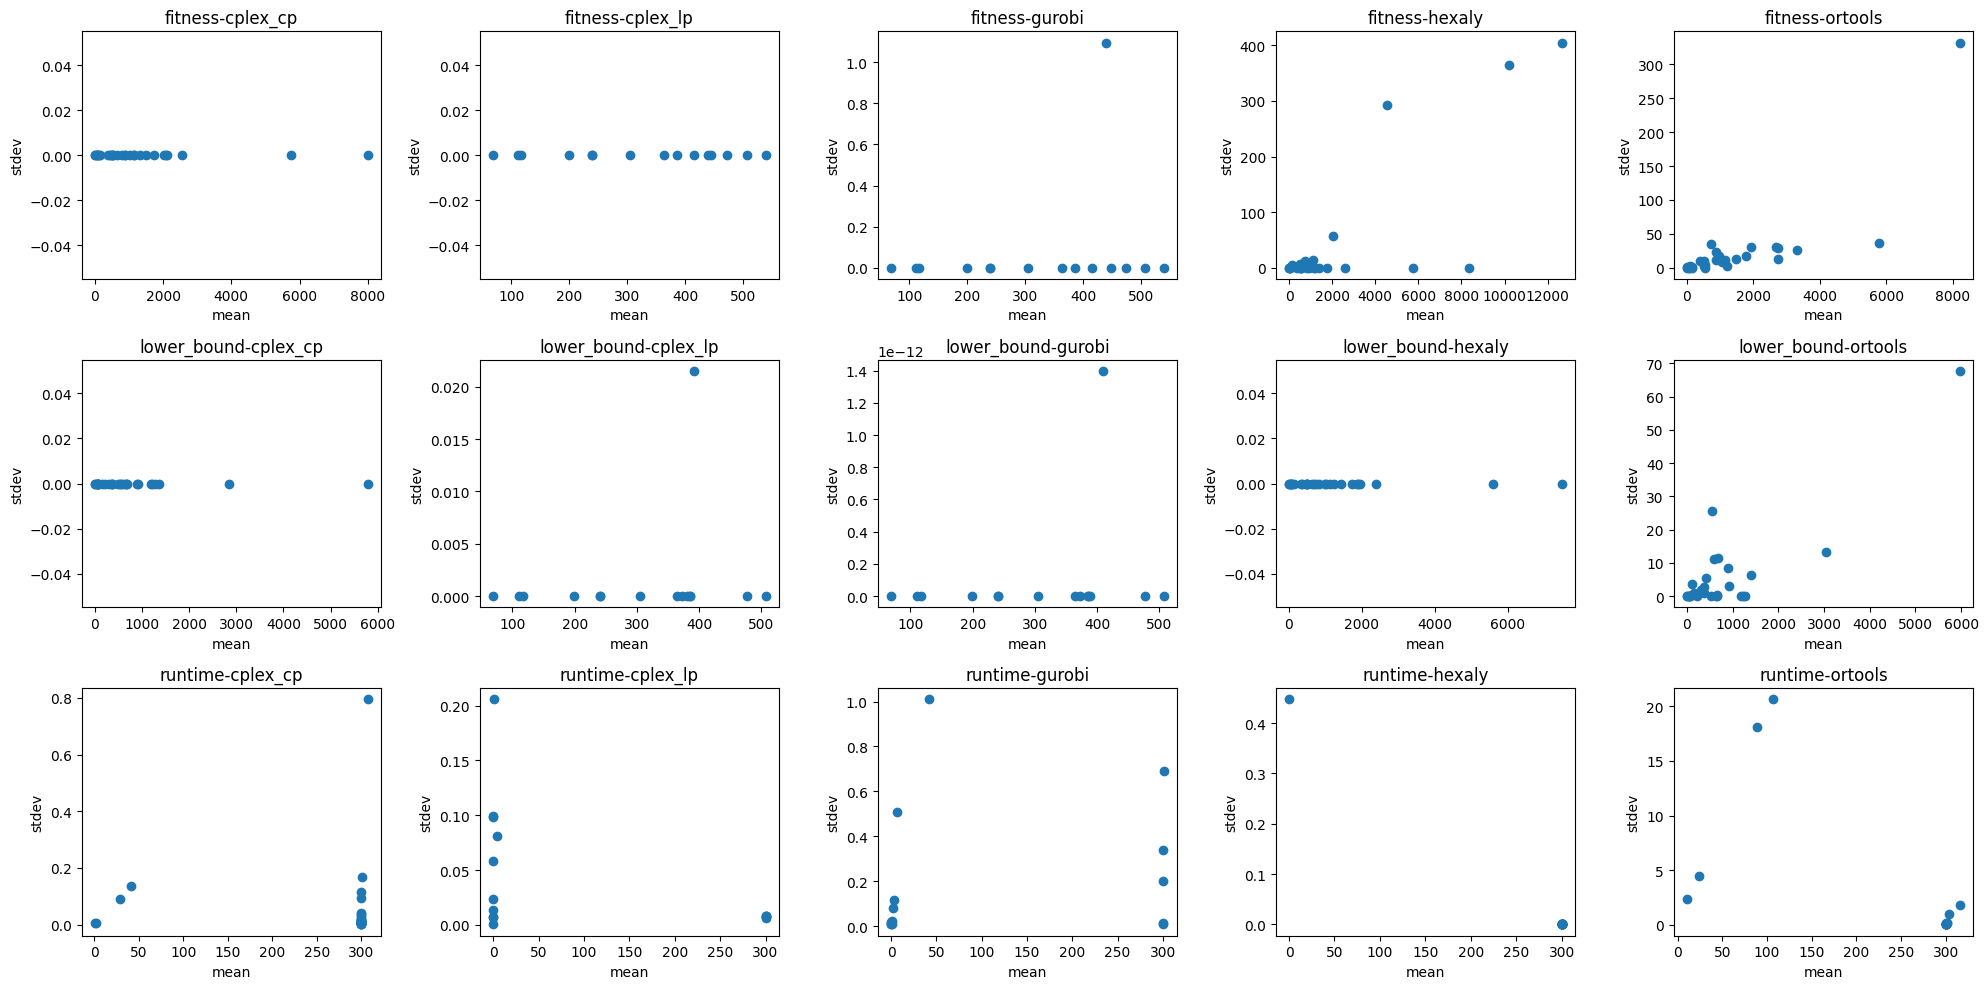

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(layout='tight', figsize=(20, 10))
axs = fig.subplots(3, len(average_results.keys()))
i = 0
for metric in ['fitness', 'lower_bound', 'runtime']:
    j = 0
    for solver in average_results:
        #if solver == 'gurobi' or solver == 'cplex_lp':
        #    continue
        x = []
        y = []
        for instance in average_results[solver]:
            x.append(average_results[solver][instance][metric][0])
            y.append(average_results[solver][instance][metric][1])
        axs[i][j].scatter(x, y, label=solver)
        axs[i][j].set_title(metric + '-' + solver)
        axs[i][j].set_xlabel('mean')
        axs[i][j].set_ylabel('stdev')
        j+=1
    i+=1
plt.show()


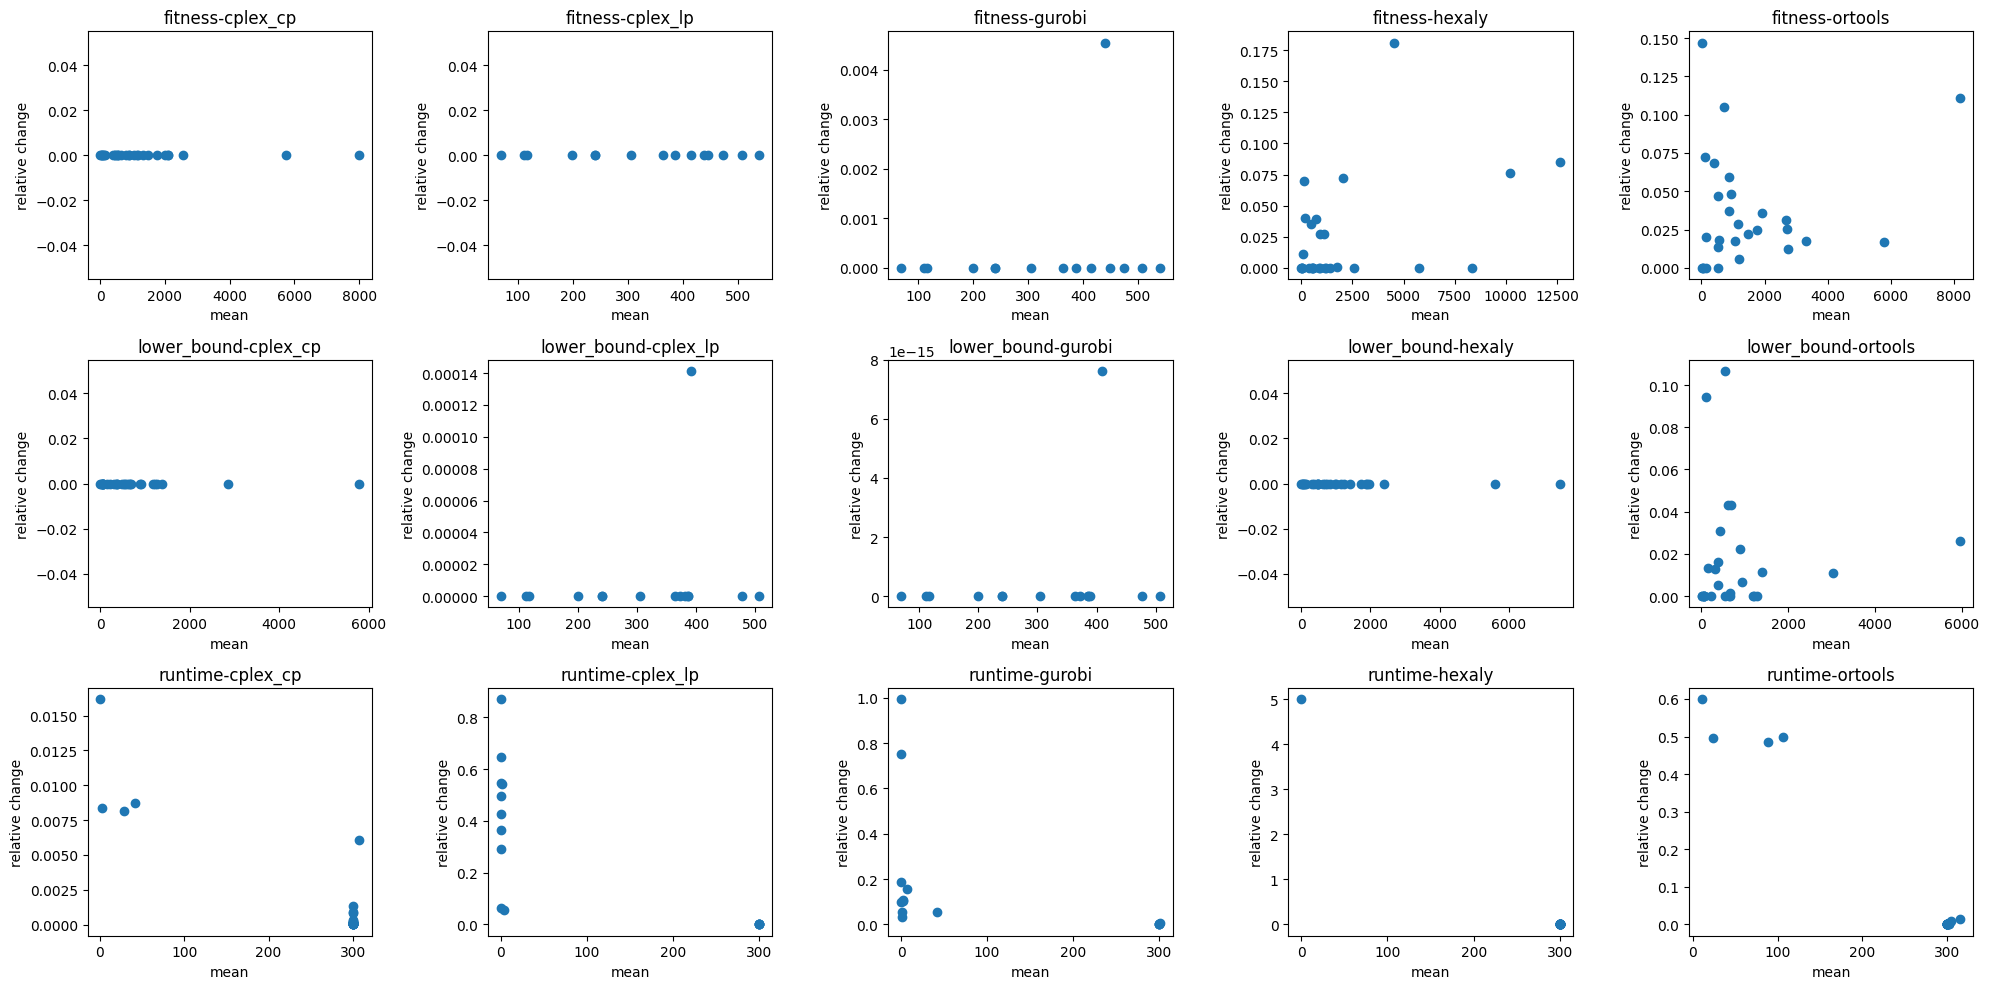

In [29]:
import matplotlib.pyplot as plt
fig = plt.figure(layout='tight', figsize=(20, 10))
axs = fig.subplots(3, len(average_results.keys()))
i = 0
for metric in ['fitness', 'lower_bound', 'runtime']:
    j = 0
    for solver in average_results:
        #if solver == 'gurobi' or solver == 'cplex_lp':
        #    continue
        x = []
        y = []
        for instance in average_results[solver]:
            x.append(average_results[solver][instance][metric][0])
            y.append(max_change[solver][instance][metric])
        axs[i][j].scatter(x, y, label=solver)
        axs[i][j].set_title(metric + '-' + solver)
        axs[i][j].set_xlabel('mean')
        axs[i][j].set_ylabel('relative change')
        j+=1
    i+=1
plt.show()


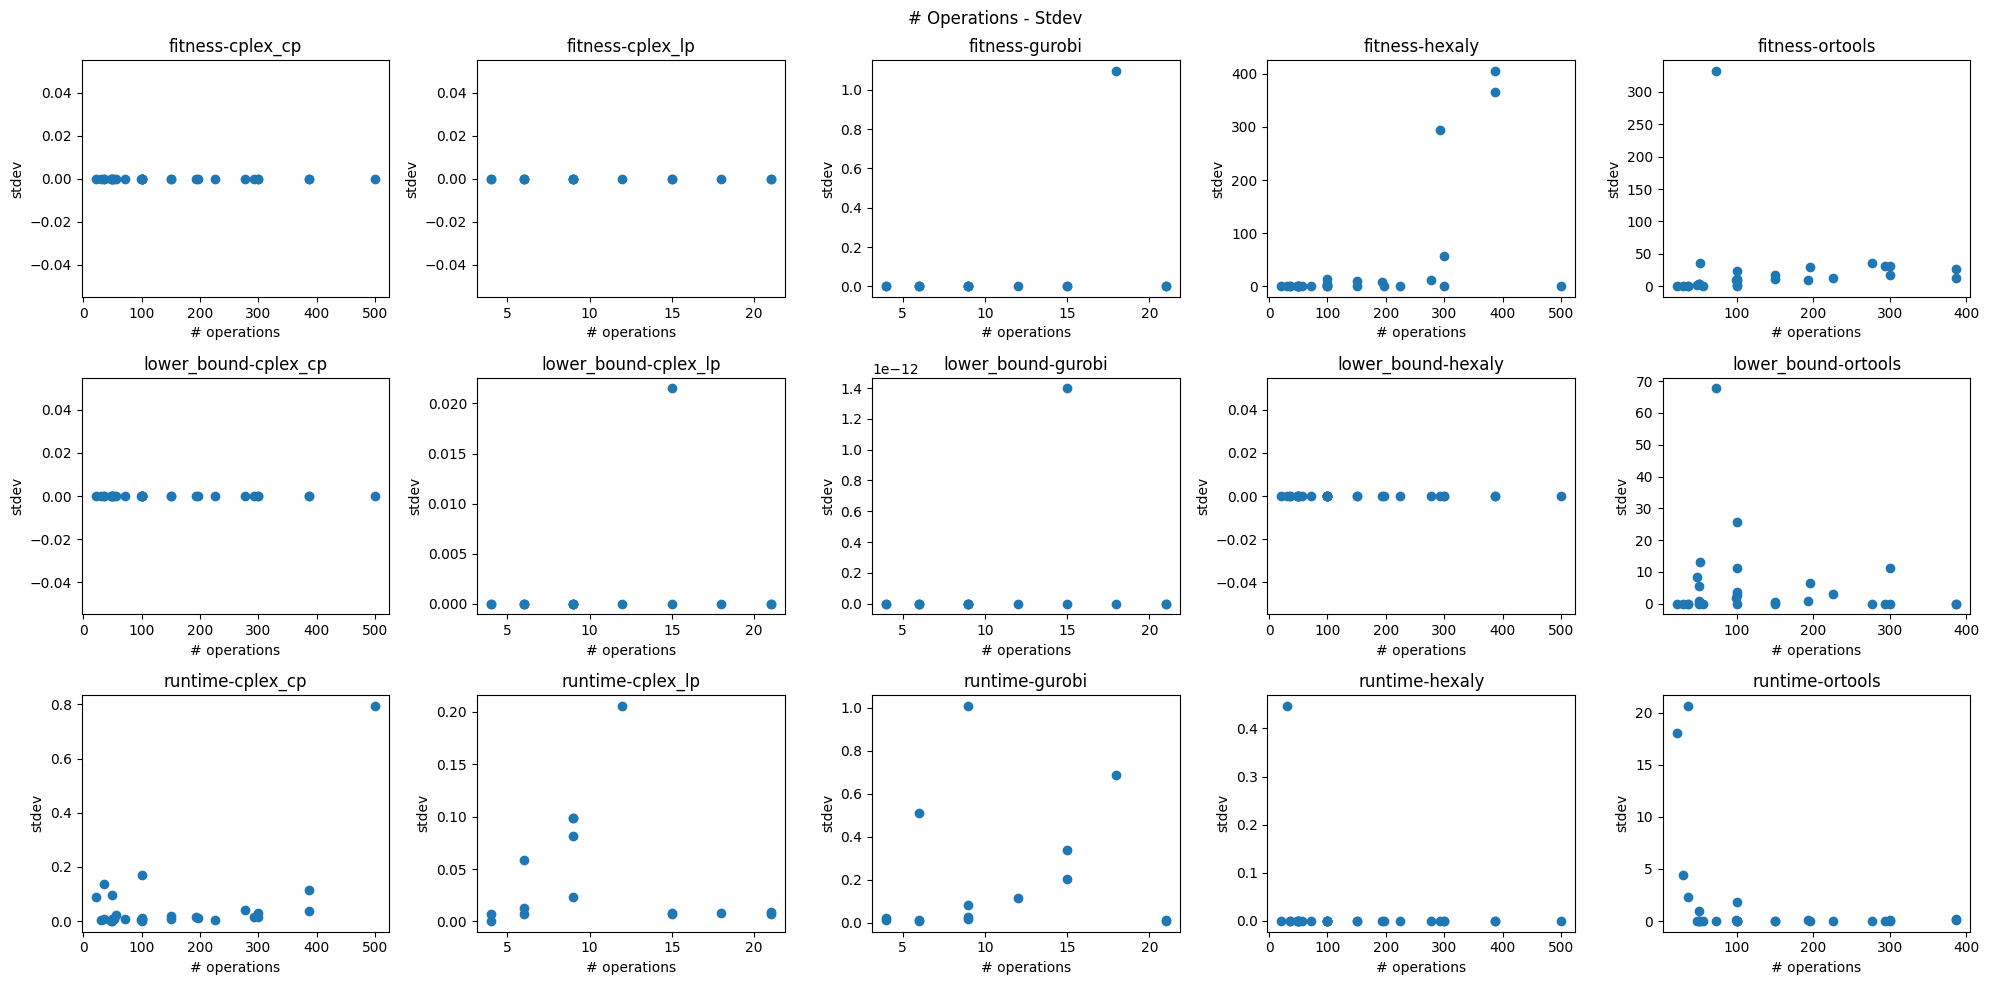

In [30]:
import matplotlib.pyplot as plt
fig = plt.figure(layout='tight', figsize=(20, 10))
fig.suptitle('# Operations - Stdev')
axs = fig.subplots(3, len(average_results.keys()))
i = 0
for metric in ['fitness', 'lower_bound', 'runtime']:
    j = 0
    for solver in average_results:
        #if solver == 'gurobi' or solver == 'cplex_lp':
        #    continue
        x = []
        y = []
        for instance in average_results[solver]:
            x.append(benchmark_data[instance]['n_operations'])
            y.append(average_results[solver][instance][metric][1])
        axs[i][j].scatter(x, y, label=solver)
        axs[i][j].set_title(metric + '-' + solver)
        axs[i][j].set_xlabel('# operations')
        axs[i][j].set_ylabel('stdev')
        j+=1
    i+=1
plt.show()


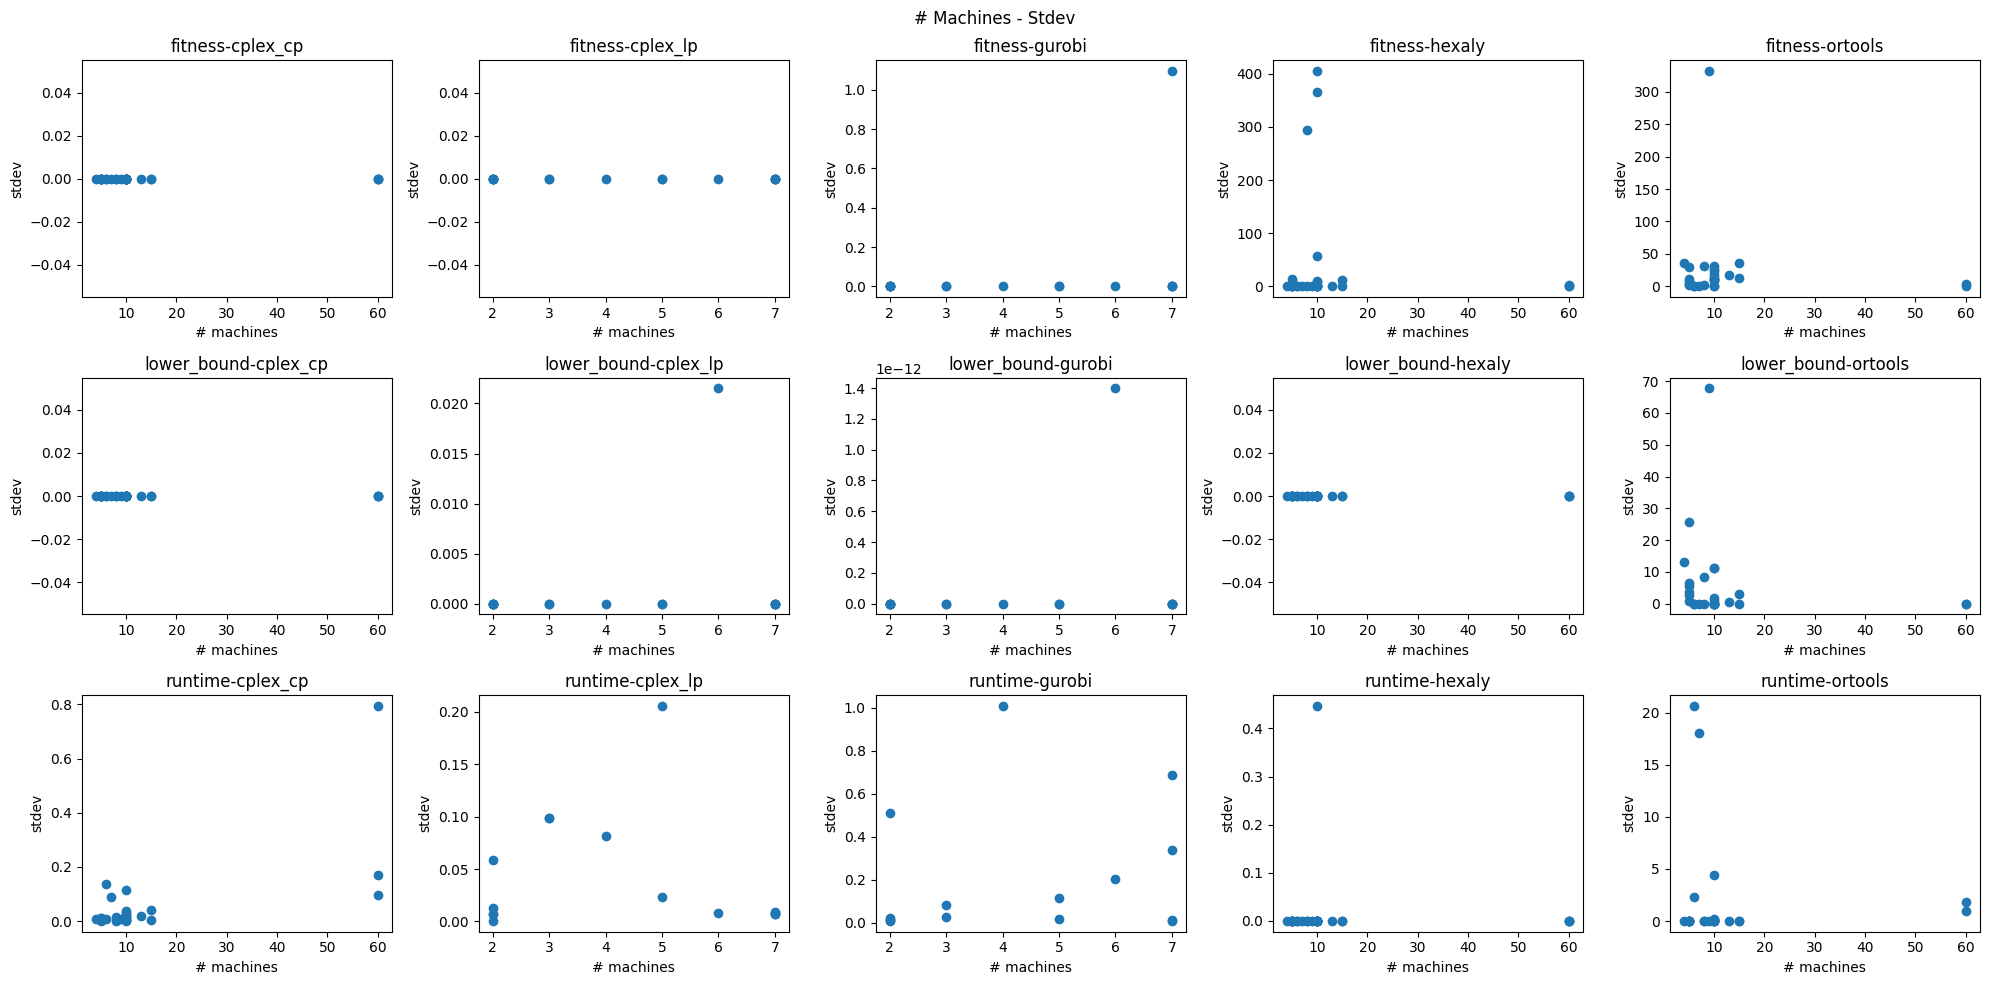

In [31]:
import matplotlib.pyplot as plt
fig = plt.figure(layout='tight', figsize=(20, 10))
fig.suptitle('# Machines - Stdev')
axs = fig.subplots(3, len(average_results.keys()))
i = 0
for metric in ['fitness', 'lower_bound', 'runtime']:
    j = 0
    for solver in average_results:
        #if solver == 'gurobi' or solver == 'cplex_lp':
        #    continue
        x = []
        y = []
        for instance in average_results[solver]:
            x.append(benchmark_data[instance]['n_machines'])
            y.append(average_results[solver][instance][metric][1])
        axs[i][j].scatter(x, y, label=solver)
        axs[i][j].set_title(metric + '-' + solver)
        axs[i][j].set_xlabel('# machines')
        axs[i][j].set_ylabel('stdev')
        j+=1
    i+=1
plt.show()


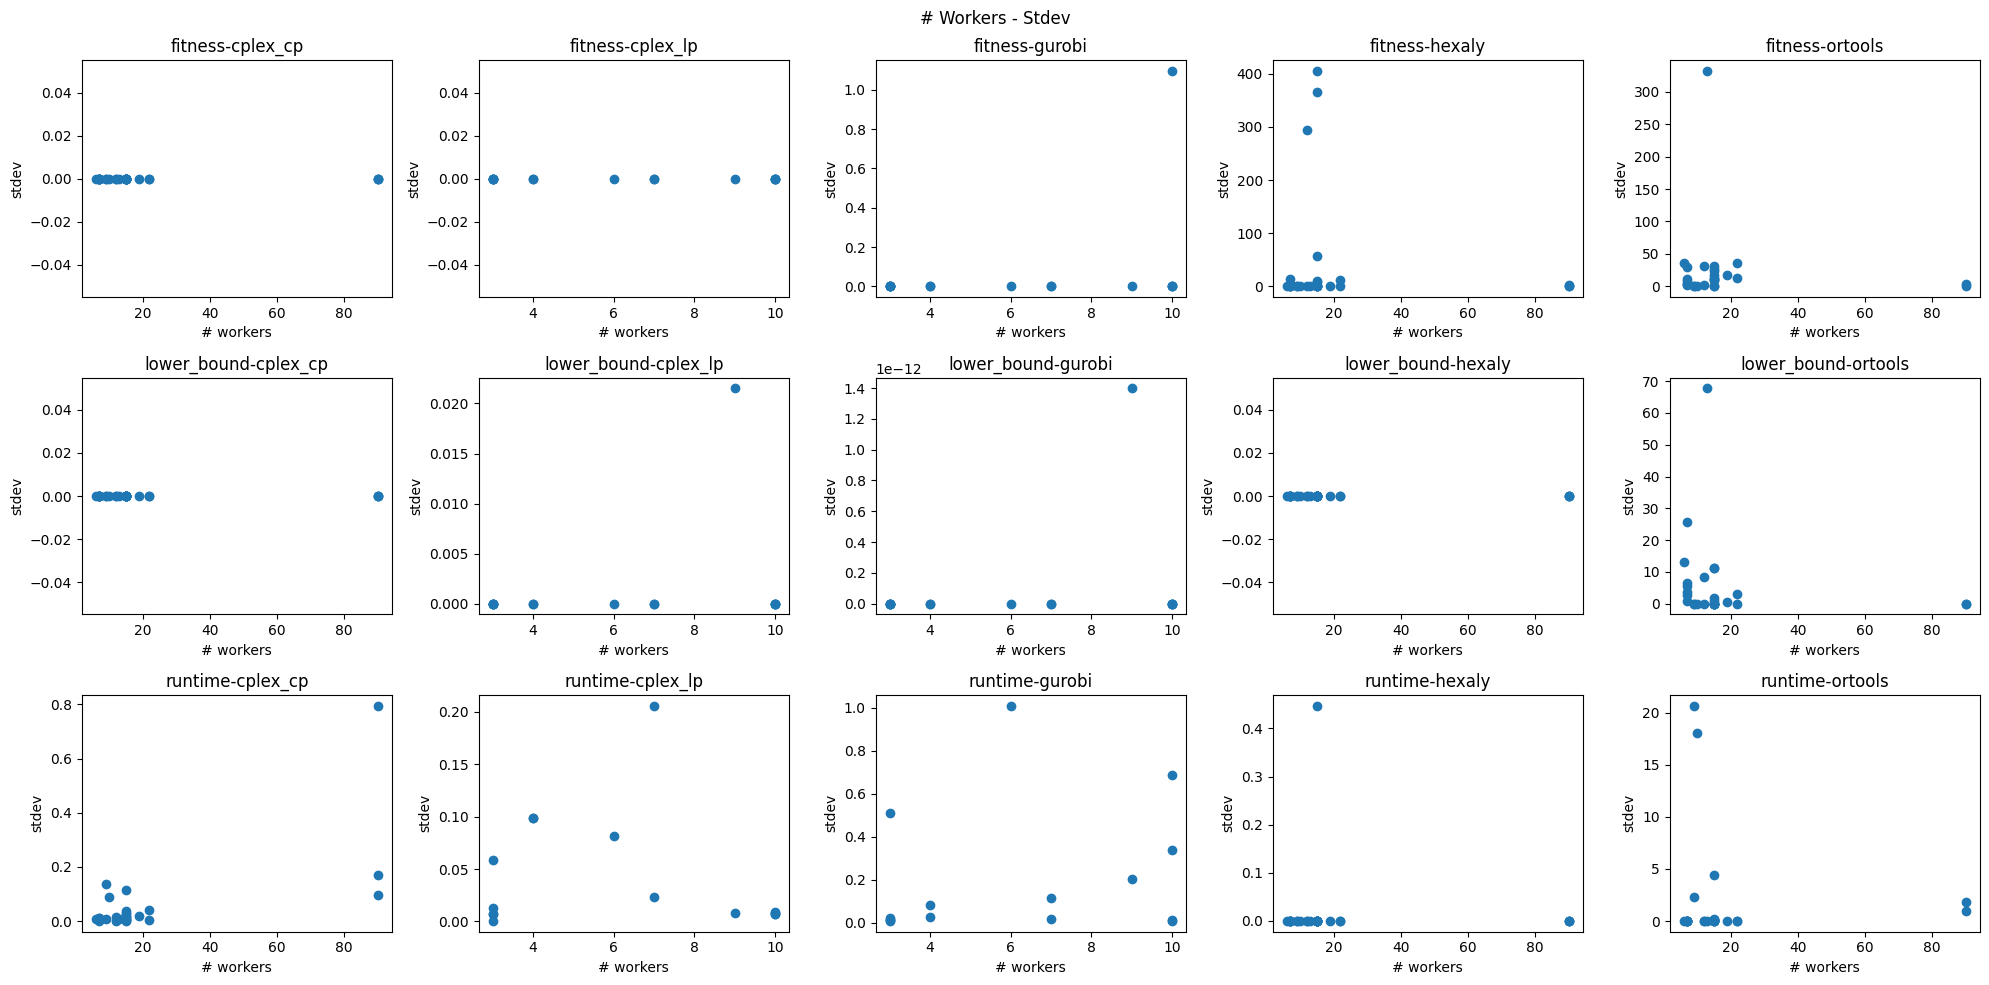

In [32]:
import matplotlib.pyplot as plt
fig = plt.figure(layout='tight', figsize=(20, 10))
fig.suptitle('# Workers - Stdev')
axs = fig.subplots(3, len(average_results.keys()))
i = 0
for metric in ['fitness', 'lower_bound', 'runtime']:
    j = 0
    for solver in average_results:
        #if solver == 'gurobi' or solver == 'cplex_lp':
        #    continue
        x = []
        y = []
        for instance in average_results[solver]:
            x.append(benchmark_data[instance]['n_workers'])
            y.append(average_results[solver][instance][metric][1])
        axs[i][j].scatter(x, y, label=solver)
        axs[i][j].set_title(metric + '-' + solver)
        axs[i][j].set_xlabel('# workers')
        axs[i][j].set_ylabel('stdev')
        j+=1
    i+=1
plt.show()


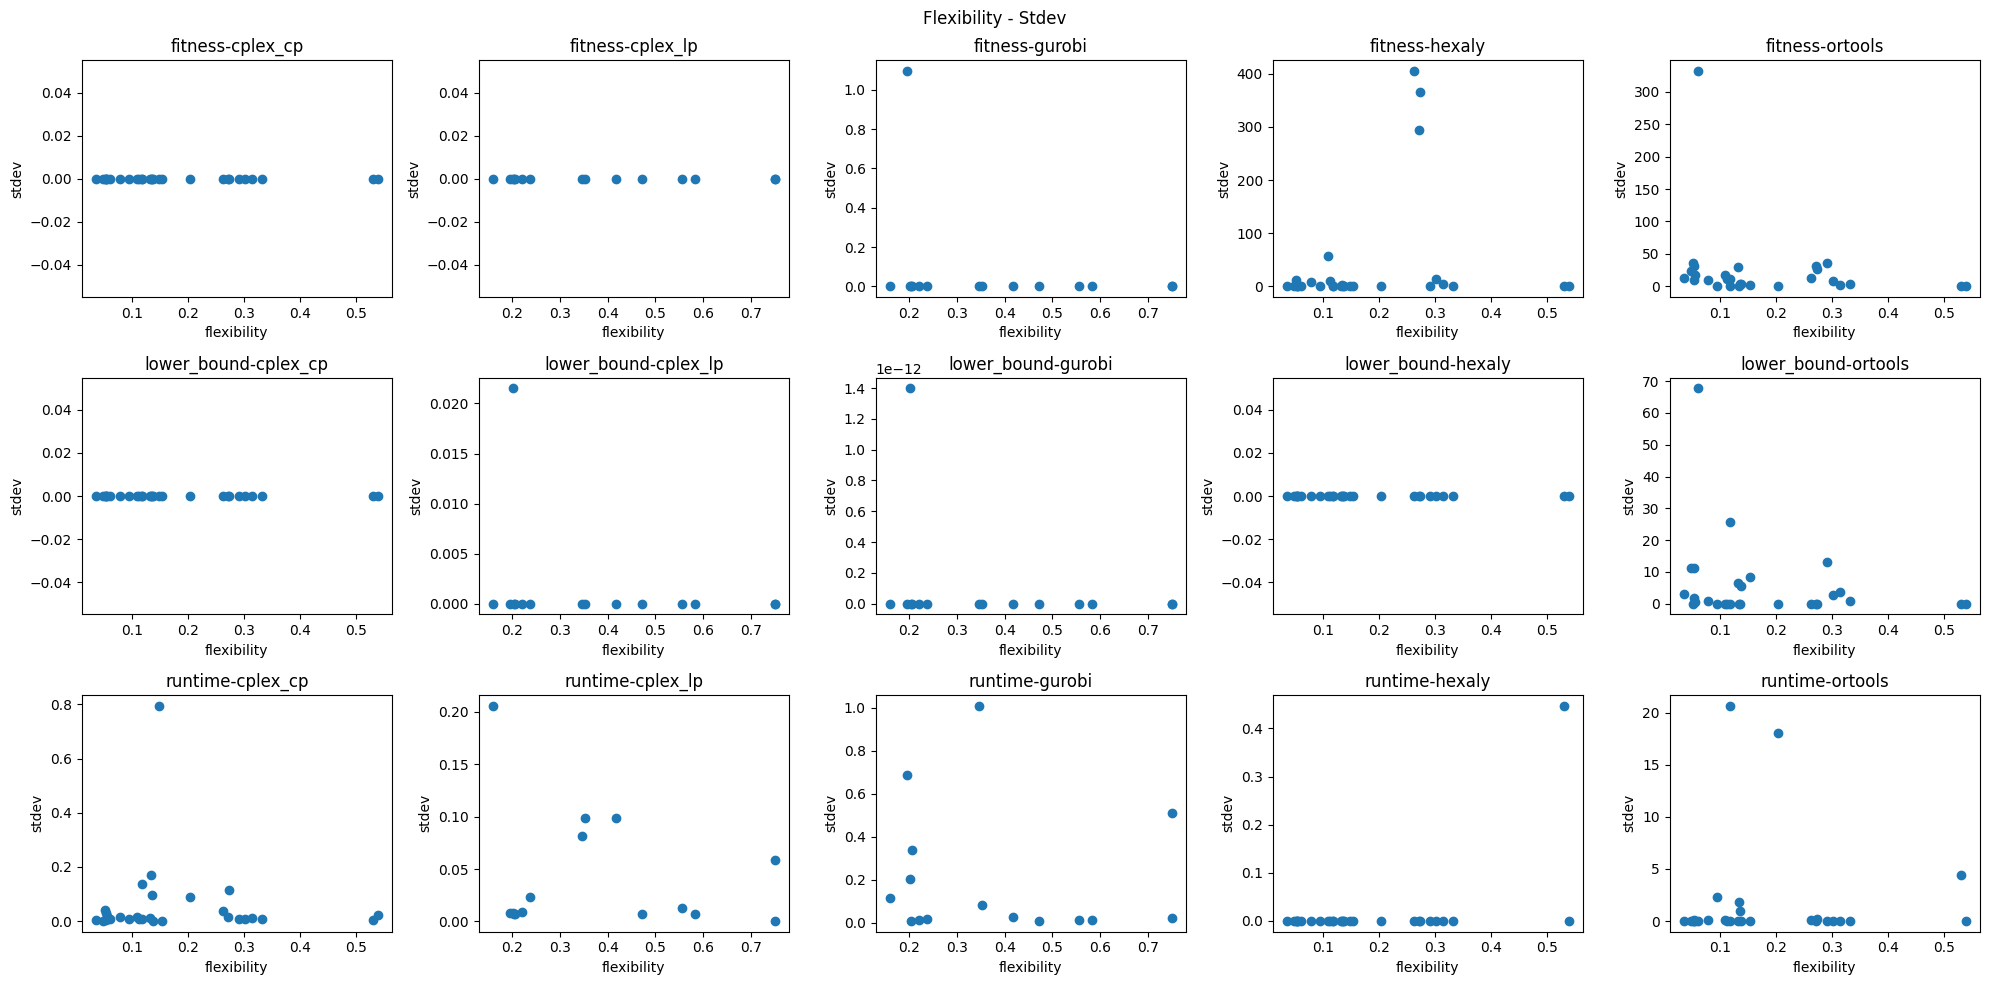

In [35]:
import matplotlib.pyplot as plt
fig = plt.figure(layout='tight', figsize=(20, 10))
fig.suptitle('Flexibility - Stdev')
axs = fig.subplots(3, len(average_results.keys()))
i = 0
for metric in ['fitness', 'lower_bound', 'runtime']:
    j = 0
    for solver in average_results:
        #if solver == 'gurobi' or solver == 'cplex_lp':
        #    continue
        x = []
        y = []
        for instance in average_results[solver]:
            x.append(benchmark_data[instance]['flexibility'])
            y.append(average_results[solver][instance][metric][1])
        axs[i][j].scatter(x, y, label=solver)
        axs[i][j].set_title(metric + '-' + solver)
        axs[i][j].set_xlabel('flexibility')
        axs[i][j].set_ylabel('stdev')
        j+=1
    i+=1
plt.show()


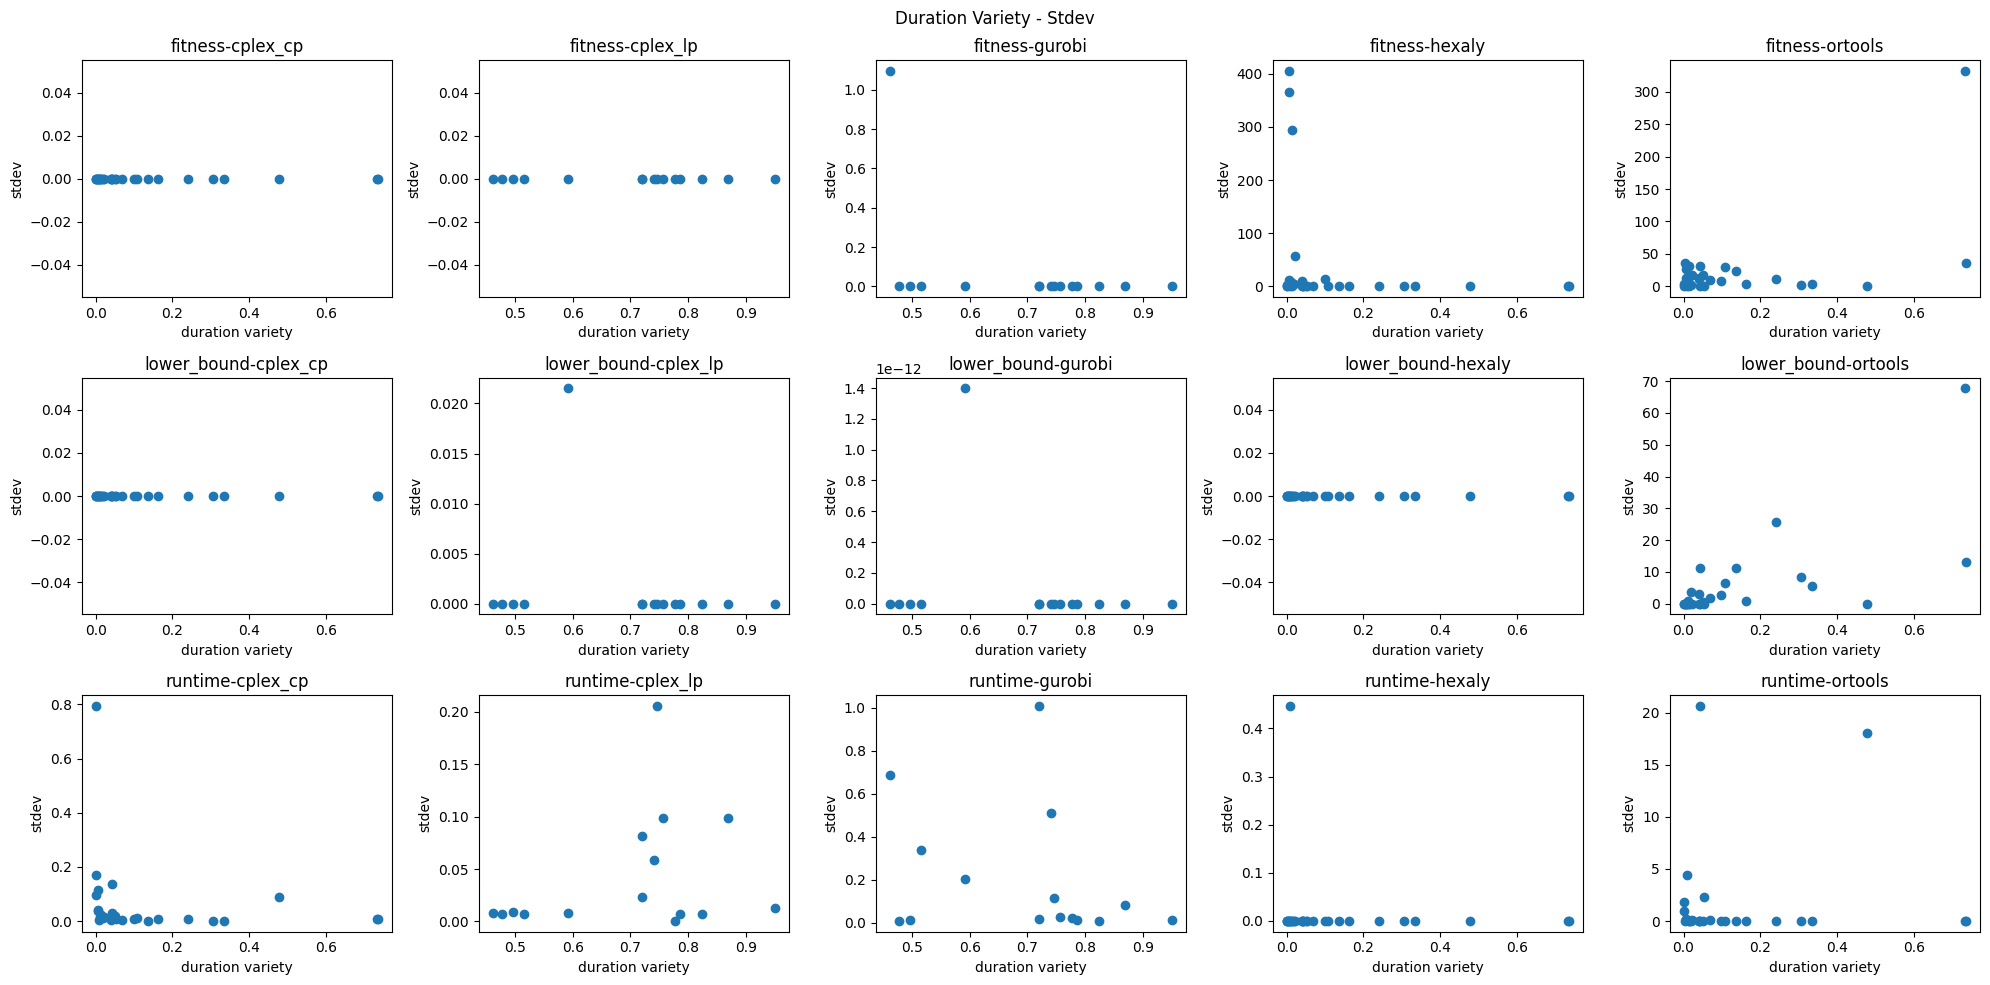

In [36]:
import matplotlib.pyplot as plt
fig = plt.figure(layout='tight', figsize=(20, 10))
fig.suptitle('Duration Variety - Stdev')
axs = fig.subplots(3, len(average_results.keys()))
i = 0
for metric in ['fitness', 'lower_bound', 'runtime']:
    j = 0
    for solver in average_results:
        #if solver == 'gurobi' or solver == 'cplex_lp':
        #    continue
        x = []
        y = []
        for instance in average_results[solver]:
            x.append(benchmark_data[instance]['duration_variety'])
            y.append(average_results[solver][instance][metric][1])
        axs[i][j].scatter(x, y, label=solver)
        axs[i][j].set_title(metric + '-' + solver)
        axs[i][j].set_xlabel('duration variety')
        axs[i][j].set_ylabel('stdev')
        j+=1
    i+=1
plt.show()


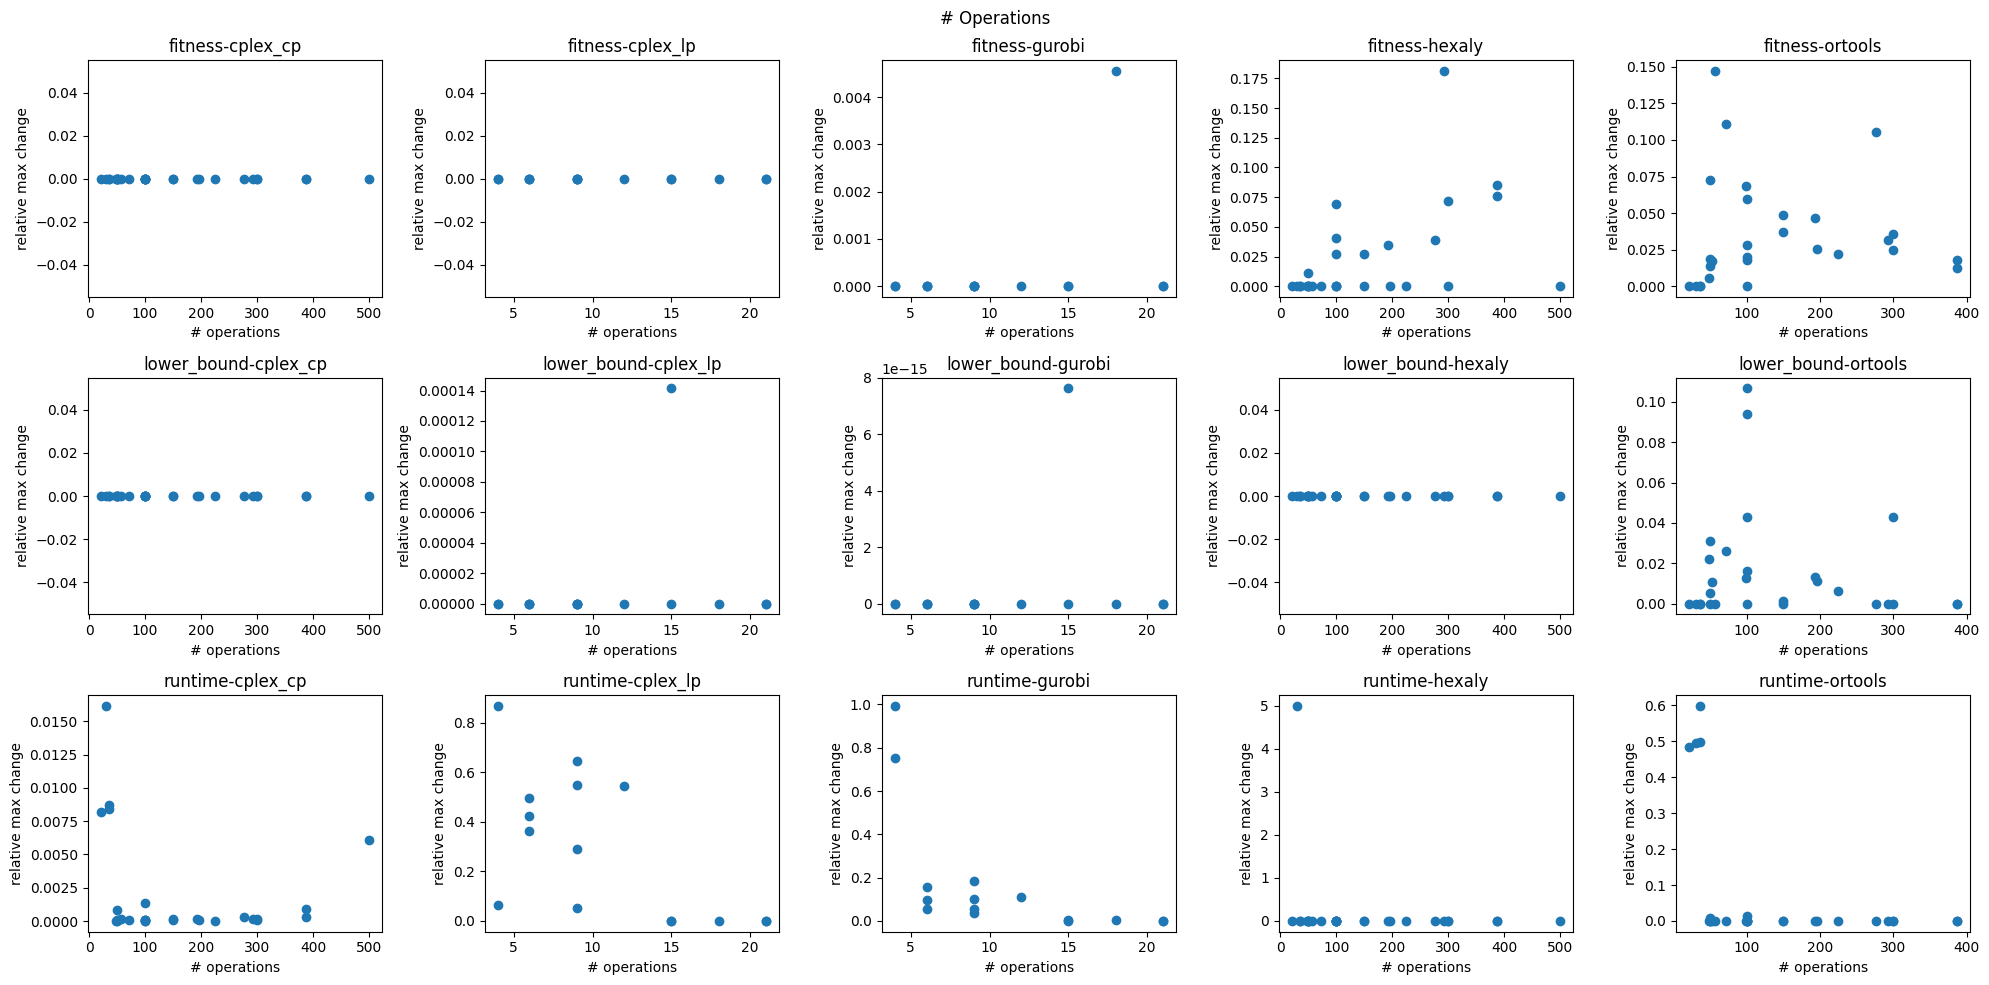

In [37]:
import matplotlib.pyplot as plt
fig = plt.figure(layout='tight', figsize=(20, 10))
fig.suptitle('# Operations')
axs = fig.subplots(3, len(average_results.keys()))
i = 0
for metric in ['fitness', 'lower_bound', 'runtime']:
    j = 0
    for solver in max_change:
        #if solver == 'gurobi' or solver == 'cplex_lp':
        #    continue
        x = []
        y = []
        for instance in max_change[solver]:
            x.append(benchmark_data[instance]['n_operations'])
            y.append(max_change[solver][instance][metric])
        axs[i][j].scatter(x, y, label=solver)
        axs[i][j].set_title(metric + '-' + solver)
        axs[i][j].set_xlabel('# operations')
        axs[i][j].set_ylabel('relative max change')
        j+=1
    i+=1
plt.show()


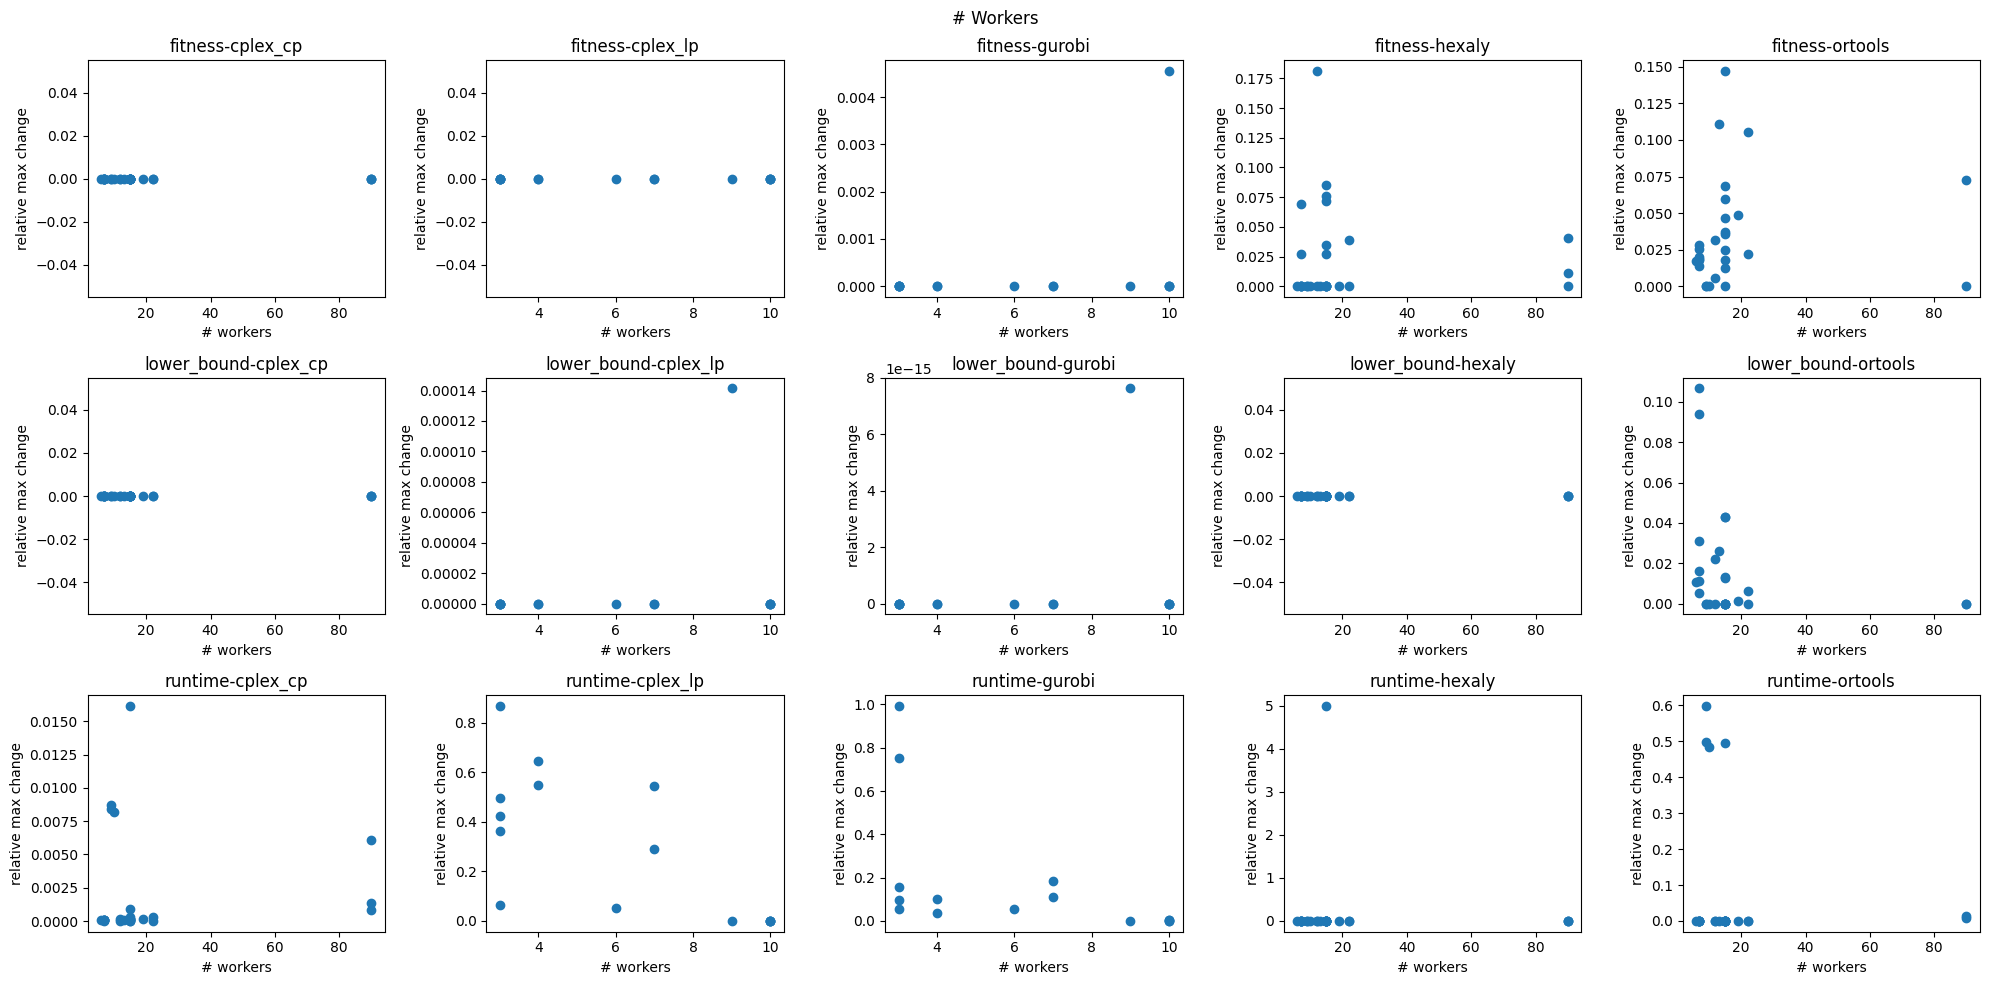

In [38]:
import matplotlib.pyplot as plt
fig = plt.figure(layout='tight', figsize=(20, 10))
fig.suptitle('# Workers')
axs = fig.subplots(3, len(average_results.keys()))
i = 0
for metric in ['fitness', 'lower_bound', 'runtime']:
    j = 0
    for solver in max_change:
        #if solver == 'gurobi' or solver == 'cplex_lp':
        #    continue
        x = []
        y = []
        for instance in max_change[solver]:
            x.append(benchmark_data[instance]['n_workers'])
            y.append(max_change[solver][instance][metric])
        axs[i][j].scatter(x, y, label=solver)
        axs[i][j].set_title(metric + '-' + solver)
        axs[i][j].set_xlabel('# workers')
        axs[i][j].set_ylabel('relative max change')
        j+=1
    i+=1
plt.show()


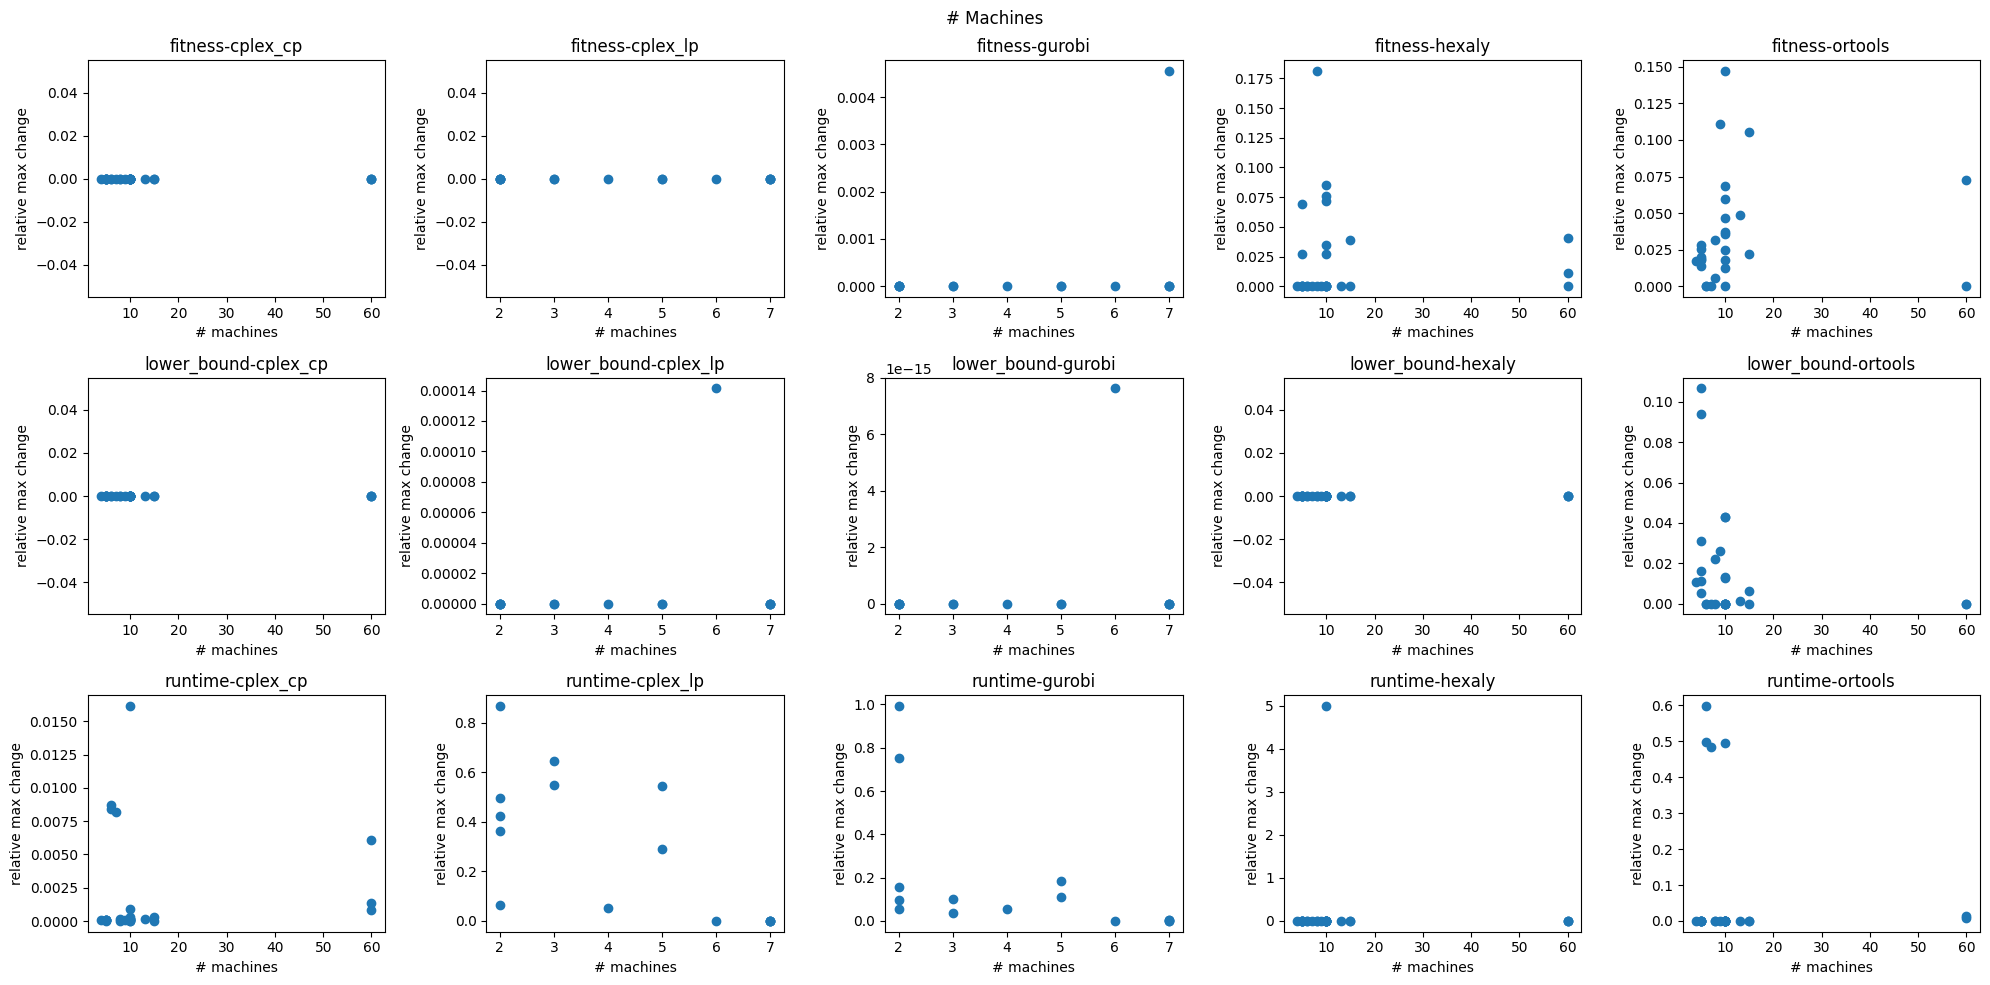

In [39]:
import matplotlib.pyplot as plt
fig = plt.figure(layout='tight', figsize=(20, 10))
fig.suptitle('# Machines')
axs = fig.subplots(3, len(average_results.keys()))
i = 0
for metric in ['fitness', 'lower_bound', 'runtime']:
    j = 0
    for solver in max_change:
        #if solver == 'gurobi' or solver == 'cplex_lp':
        #    continue
        x = []
        y = []
        for instance in max_change[solver]:
            x.append(benchmark_data[instance]['n_machines'])
            y.append(max_change[solver][instance][metric])
        axs[i][j].scatter(x, y, label=solver)
        axs[i][j].set_title(metric + '-' + solver)
        axs[i][j].set_xlabel('# machines')
        axs[i][j].set_ylabel('relative max change')
        j+=1
    i+=1
plt.show()


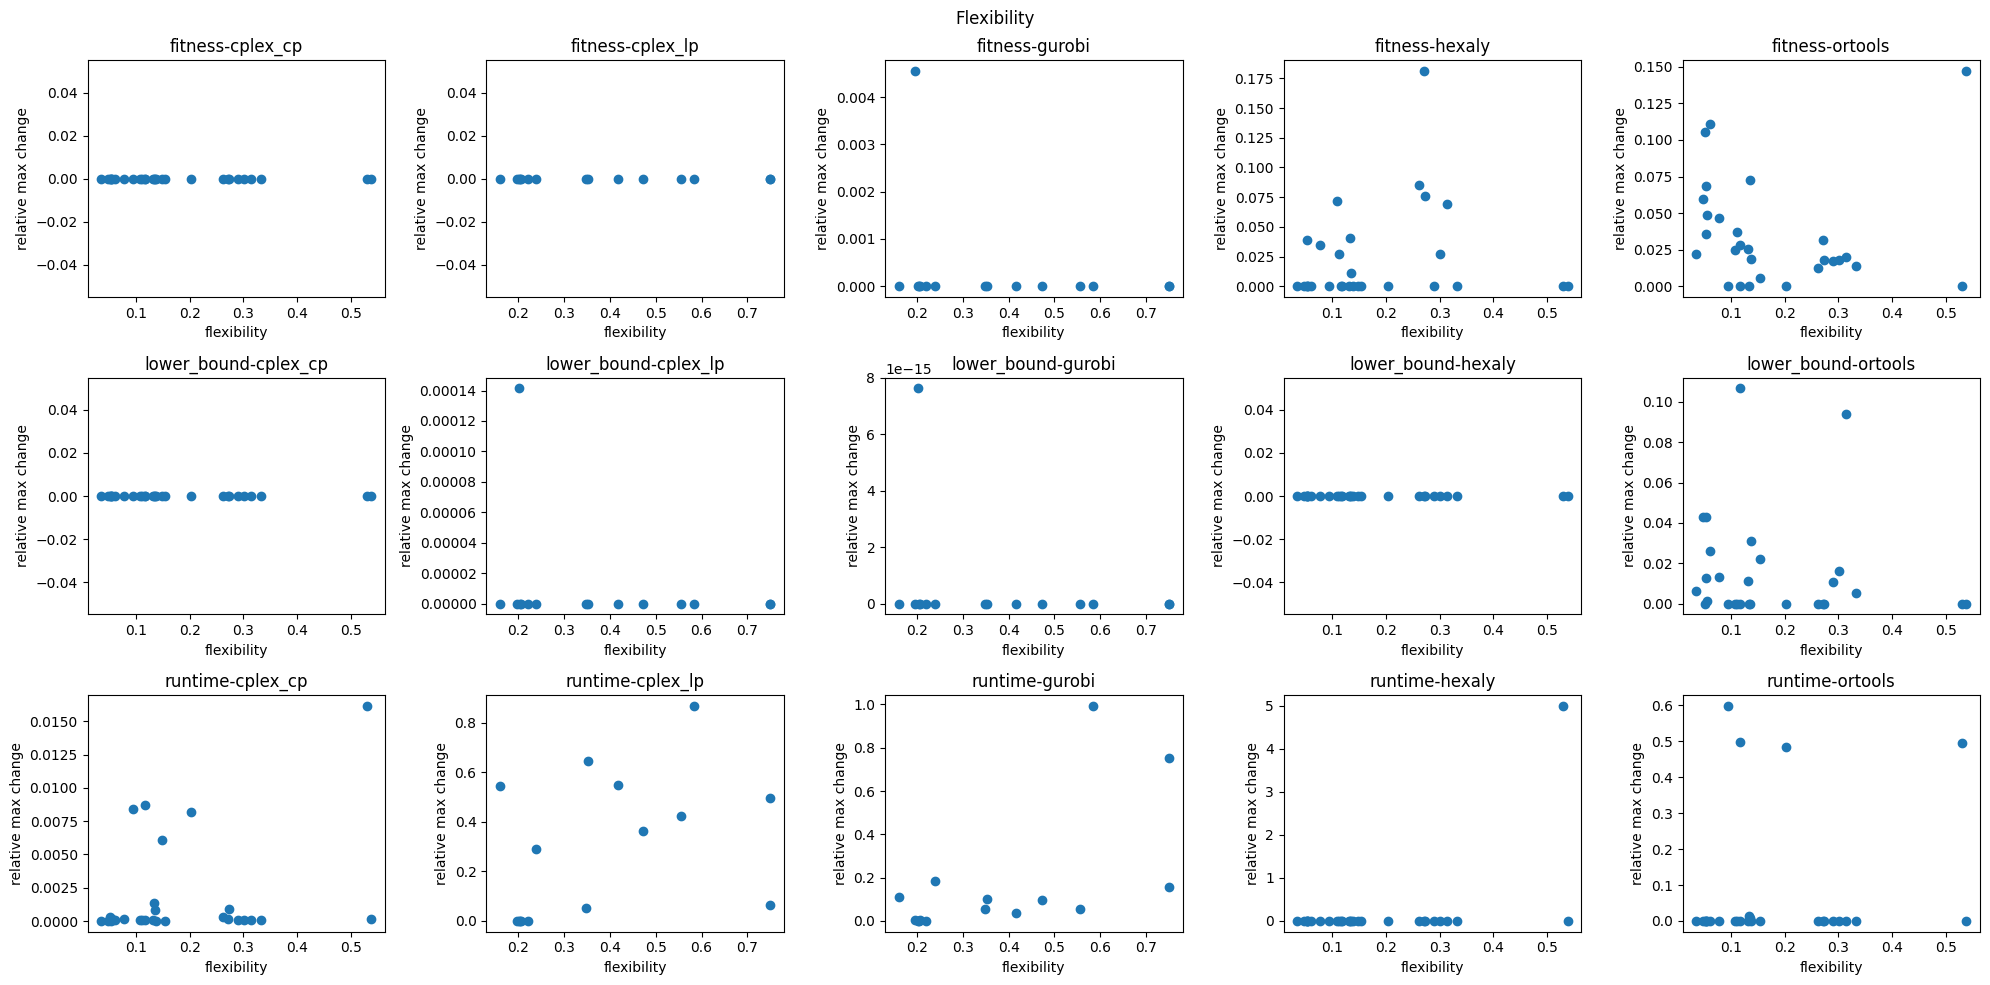

In [40]:
import matplotlib.pyplot as plt
fig = plt.figure(layout='tight', figsize=(20, 10))
fig.suptitle('Flexibility')
axs = fig.subplots(3, len(average_results.keys()))
i = 0
for metric in ['fitness', 'lower_bound', 'runtime']:
    j = 0
    for solver in max_change:
        #if solver == 'gurobi' or solver == 'cplex_lp':
        #    continue
        x = []
        y = []
        for instance in max_change[solver]:
            x.append(benchmark_data[instance]['flexibility'])
            y.append(max_change[solver][instance][metric])
        axs[i][j].scatter(x, y, label=solver)
        axs[i][j].set_title(metric + '-' + solver)
        axs[i][j].set_xlabel('flexibility')
        axs[i][j].set_ylabel('relative max change')
        j+=1
    i+=1
plt.show()


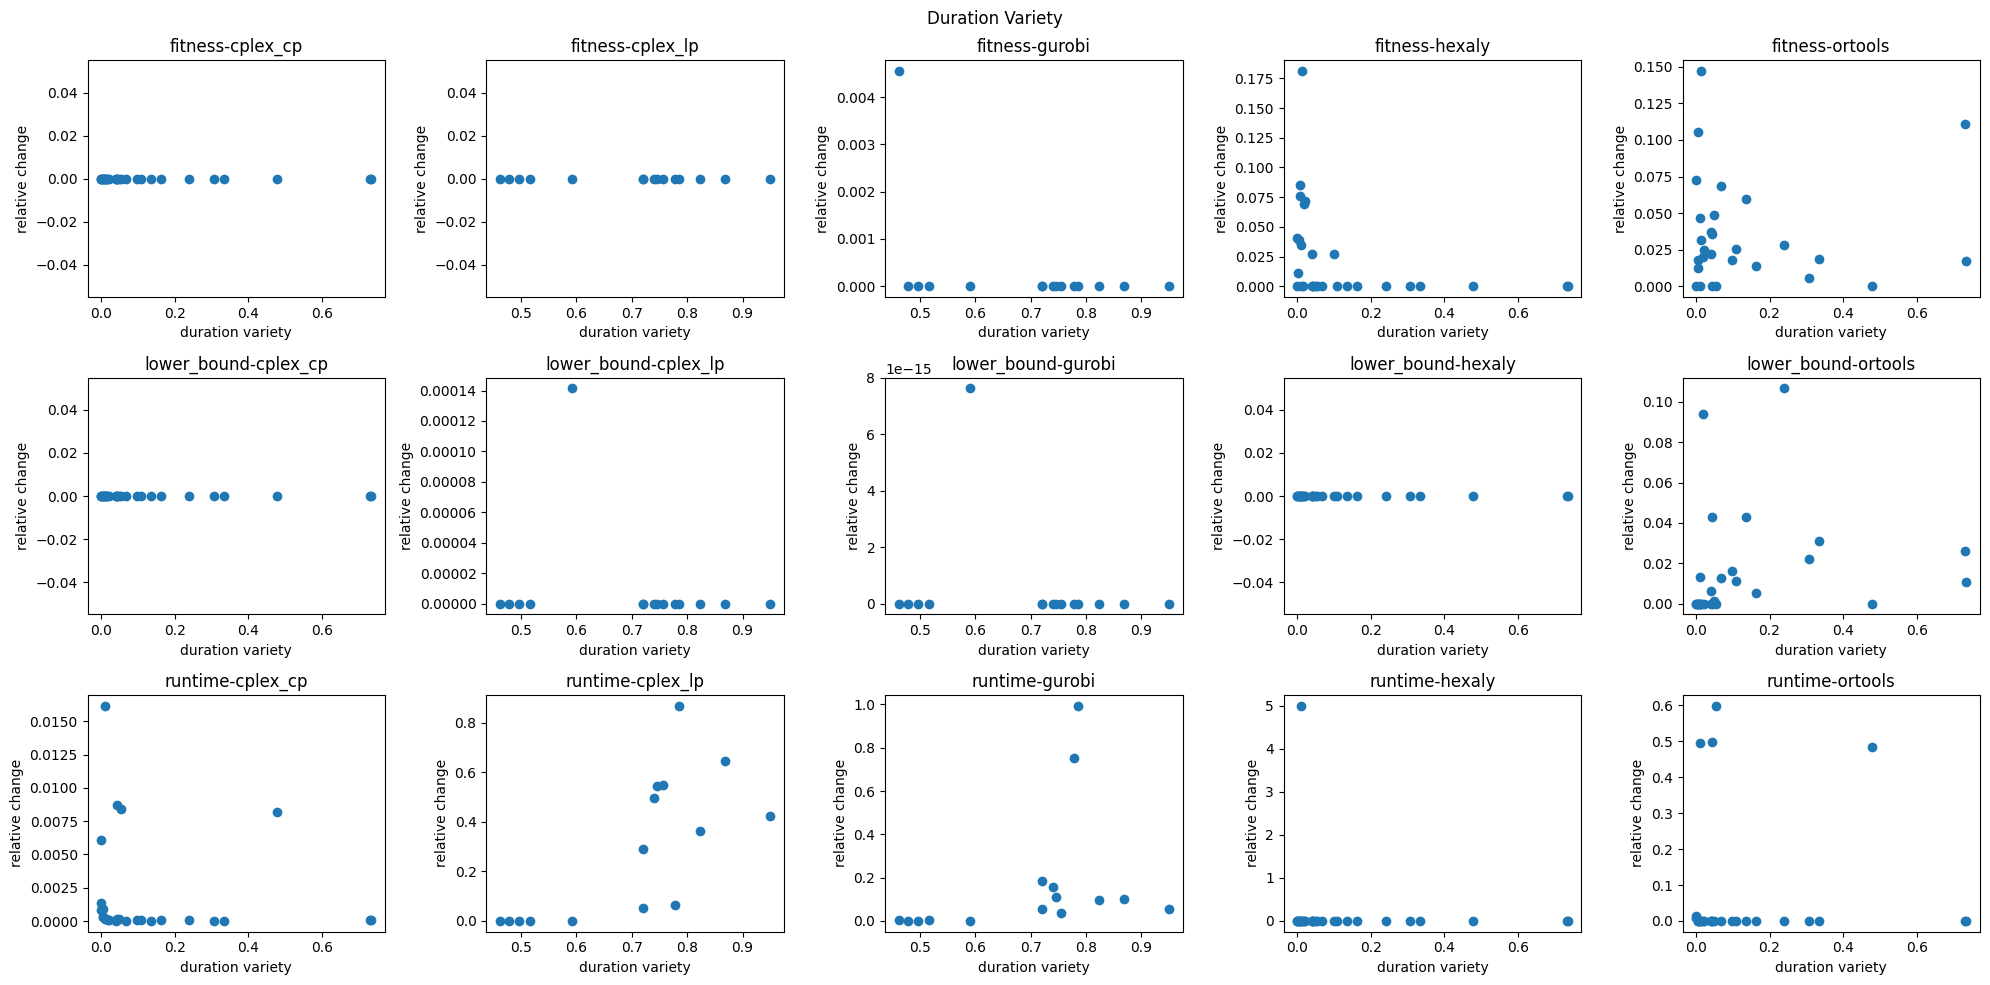

In [41]:
import matplotlib.pyplot as plt
fig = plt.figure(layout='tight', figsize=(20, 10))
fig.suptitle('Duration Variety')
axs = fig.subplots(3, len(average_results.keys()))
i = 0
for metric in ['fitness', 'lower_bound', 'runtime']:
    j = 0
    for solver in max_change:
        #if solver == 'gurobi' or solver == 'cplex_lp':
        #    continue
        x = []
        y = []
        for instance in max_change[solver]:
            x.append(benchmark_data[instance]['duration_variety'])
            y.append(max_change[solver][instance][metric])
        axs[i][j].scatter(x, y, label=solver)
        axs[i][j].set_title(metric + '-' + solver)
        axs[i][j].set_xlabel('duration variety')
        axs[i][j].set_ylabel('relative change')
        j+=1
    i+=1
plt.show()


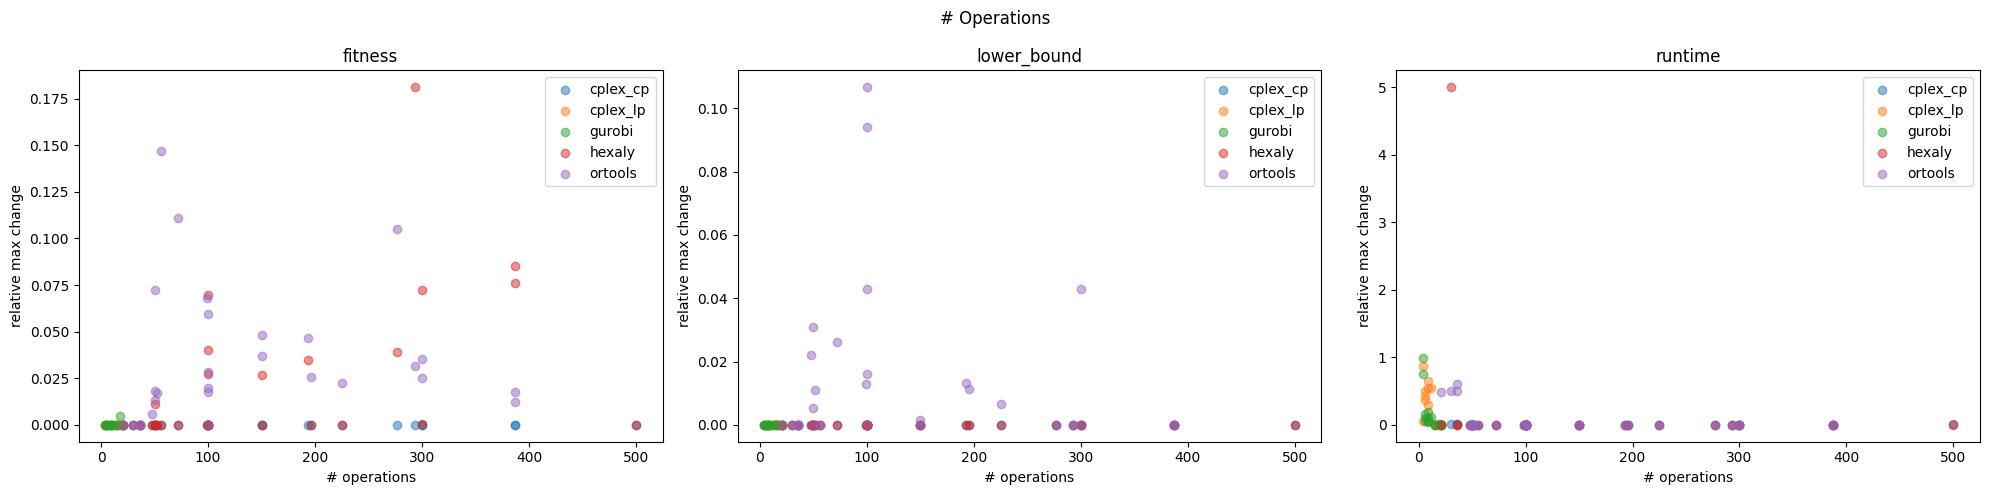

: 

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(layout='tight', figsize=(20, 5))
fig.suptitle('# Operations')
axs = fig.subplots(1, 3)
i = 0
for metric in ['fitness', 'lower_bound', 'runtime']:
    j = 0
    for solver in max_change:
        #if solver == 'gurobi' or solver == 'cplex_lp':
        #    continue
        x = []
        y = []
        for instance in max_change[solver]:
            x.append(benchmark_data[instance]['n_operations'])
            y.append(max_change[solver][instance][metric])
        axs[i].scatter(x, y, label=solver, alpha=0.5)
        axs[i].set_title(metric)
        axs[i].set_xlabel('# operations')
        axs[i].set_ylabel('relative max change')
        axs[i].legend()
        #j+=1
    i+=1

plt.show()


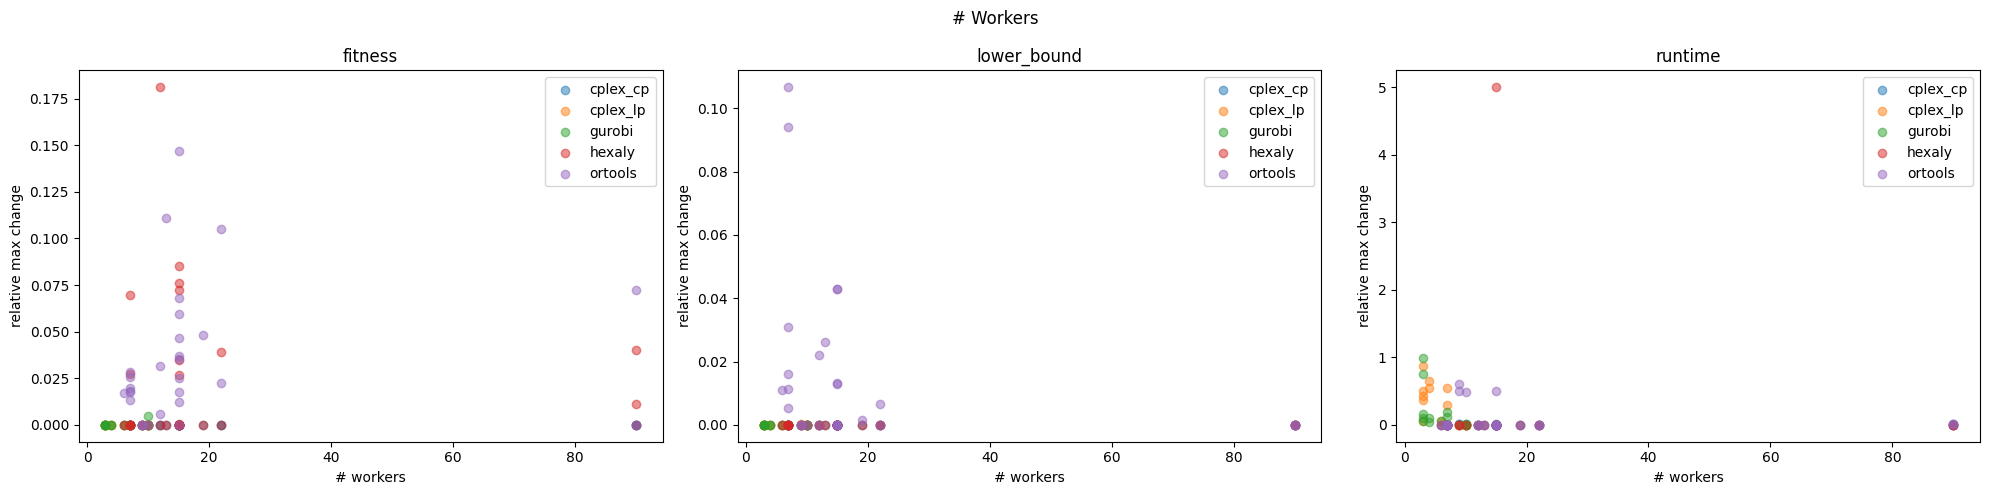

In [50]:
import matplotlib.pyplot as plt
fig = plt.figure(layout='tight', figsize=(20, 5))
fig.suptitle('# Workers')
axs = fig.subplots(1, 3)
i = 0
for metric in ['fitness', 'lower_bound', 'runtime']:
    j = 0
    for solver in max_change:
        #if solver == 'gurobi' or solver == 'cplex_lp':
        #    continue
        x = []
        y = []
        for instance in max_change[solver]:
            x.append(benchmark_data[instance]['n_workers'])
            y.append(max_change[solver][instance][metric])
        axs[i].scatter(x, y, label=solver, alpha=0.5)
        axs[i].set_title(metric)
        axs[i].set_xlabel('# workers')
        axs[i].set_ylabel('relative max change')
        axs[i].legend()
        #j+=1
    i+=1

plt.show()


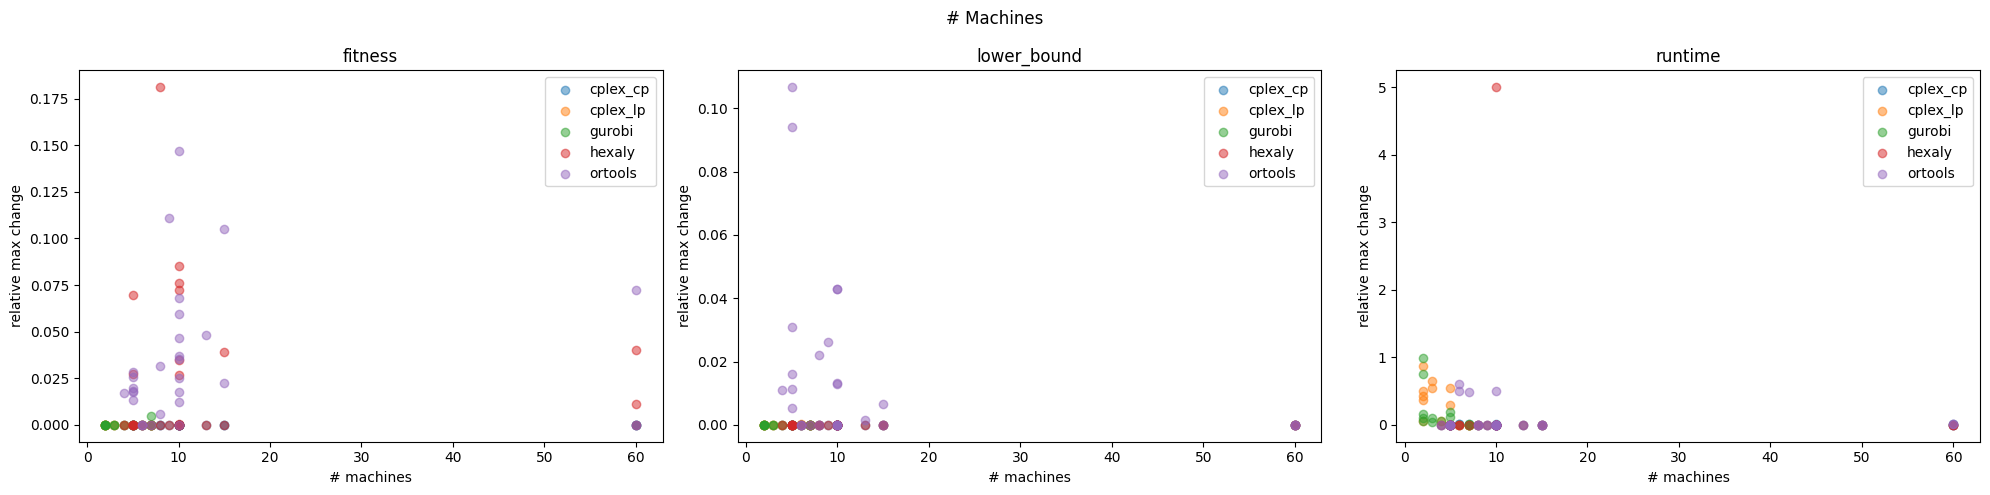

In [49]:
import matplotlib.pyplot as plt
fig = plt.figure(layout='tight', figsize=(20, 5))
fig.suptitle('# Machines')
axs = fig.subplots(1, 3)
i = 0
for metric in ['fitness', 'lower_bound', 'runtime']:
    j = 0
    for solver in max_change:
        #if solver == 'gurobi' or solver == 'cplex_lp':
        #    continue
        x = []
        y = []
        for instance in max_change[solver]:
            x.append(benchmark_data[instance]['n_machines'])
            y.append(max_change[solver][instance][metric])
        axs[i].scatter(x, y, label=solver, alpha=0.5)
        axs[i].set_title(metric)
        axs[i].set_xlabel('# machines')
        axs[i].set_ylabel('relative max change')
        axs[i].legend()
        #j+=1
    i+=1

plt.show()


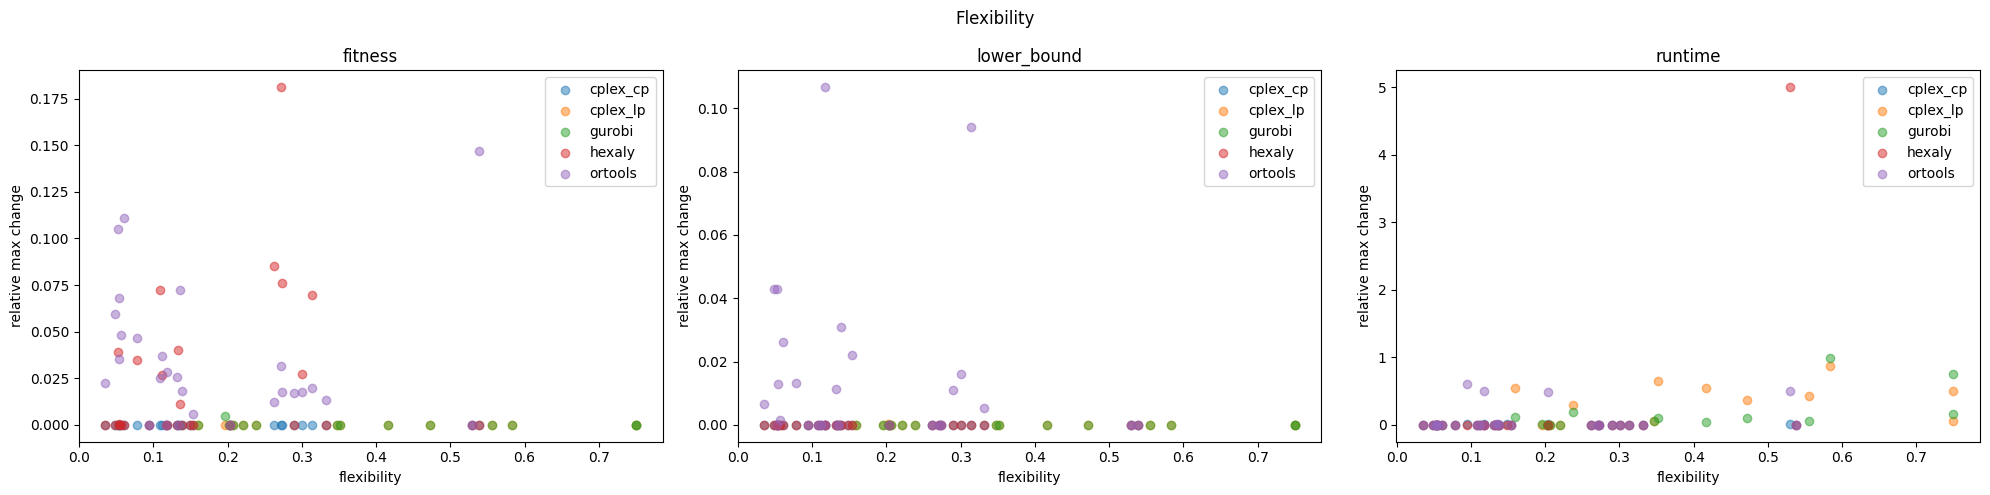

In [48]:
import matplotlib.pyplot as plt
fig = plt.figure(layout='tight', figsize=(20, 5))
fig.suptitle('Flexibility')
axs = fig.subplots(1, 3)
i = 0
for metric in ['fitness', 'lower_bound', 'runtime']:
    j = 0
    for solver in max_change:
        #if solver == 'gurobi' or solver == 'cplex_lp':
        #    continue
        x = []
        y = []
        for instance in max_change[solver]:
            x.append(benchmark_data[instance]['flexibility'])
            y.append(max_change[solver][instance][metric])
        axs[i].scatter(x, y, label=solver, alpha=0.5)
        axs[i].set_title(metric)
        axs[i].set_xlabel('flexibility')
        axs[i].set_ylabel('relative max change')
        axs[i].legend()
        #j+=1
    i+=1

plt.show()


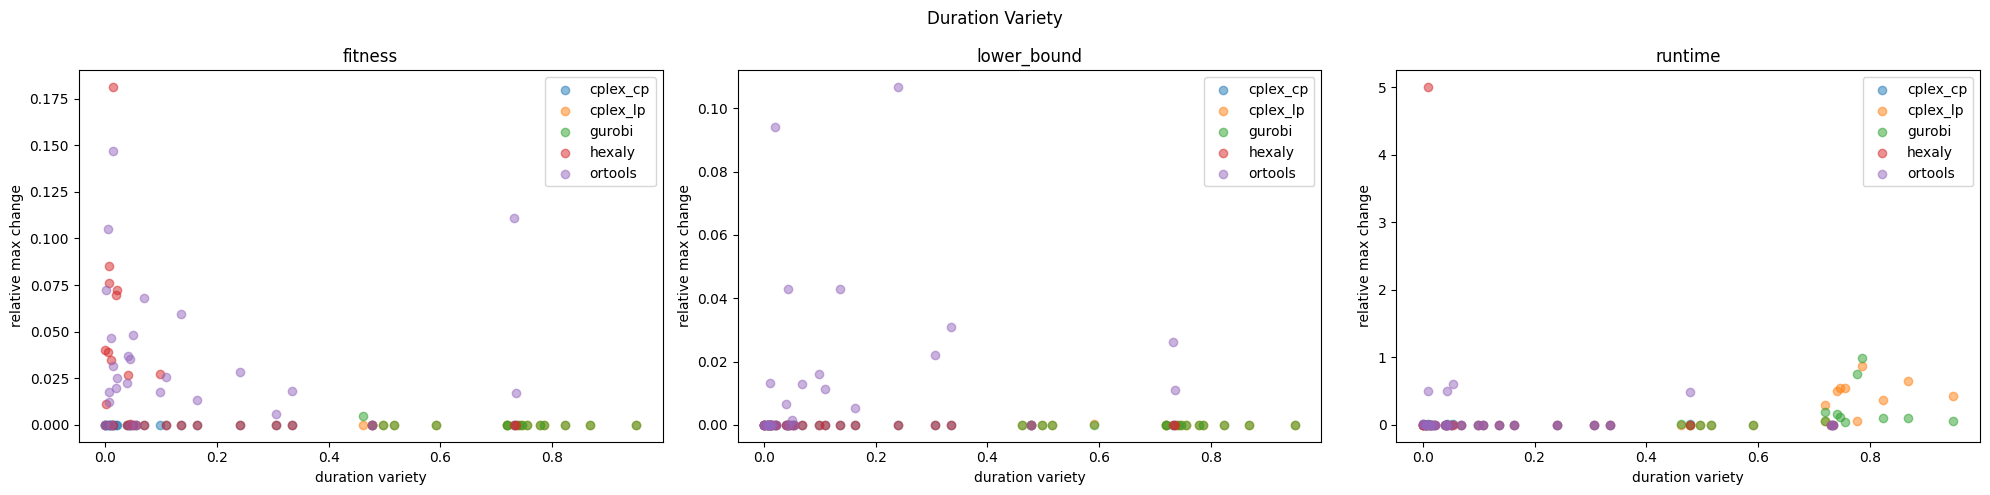

In [47]:
import matplotlib.pyplot as plt
fig = plt.figure(layout='tight', figsize=(20, 5))
fig.suptitle('Duration Variety')
axs = fig.subplots(1, 3)
i = 0
for metric in ['fitness', 'lower_bound', 'runtime']:
    j = 0
    for solver in max_change:
        #if solver == 'gurobi' or solver == 'cplex_lp':
        #    continue
        x = []
        y = []
        for instance in max_change[solver]:
            x.append(benchmark_data[instance]['duration_variety'])
            y.append(max_change[solver][instance][metric])
        axs[i].scatter(x, y, label=solver, alpha=0.5)
        axs[i].set_title(metric)
        axs[i].set_xlabel('duration variety')
        axs[i].set_ylabel('relative max change')
        axs[i].legend()
        #j+=1
    i+=1

plt.show()
